## Notebook objectives

Would We get the same results if We had used fewer features? 

How good is the models using only the main study variables (Sales, Profit, Discount and Shipping Cost)?

## Agenda

[Business Context](#Business-Context)<br> 
&emsp;[Business Questions](#Business-Questions)<br>

[Imports](#Imports)<br>
&emsp;[Helper Functions and Classes](#Helper-Functions-and-Classes)<br>


[Settings](#Settings)<br>

[Loading Data](#Loading-Data)<br>
&emsp;[df_payments](#df_payments)<br>
&emsp;[df_products](#df_products)<br>
&emsp;[df_order_items](#df_order_items)<br>
&emsp;[df_geolocations](#df_geolocations)<br>
&emsp;[df_customers](#df_customers)<br>


[Analytical Base Table](#Analytical-Base-Table)<br>
&emsp;[ABT Metadata](#ABT-Metadata)<br>
&emsp;[df_payment_abt](#df_payment_abt)<br>
&emsp;[df_orders_abt](#df_orders_abt)<br>
&emsp;[df_geolocation_abt](#df_geolocation_abt)<br>

[Feature Selection](#Feature-Selection)<br>

[Preprocessing](#Preprocessing)<br>

[Clustering](#Clustering)<br>
&emsp;[K-Means](#K-Means)<br>
&emsp;[DBSCAN](#DBSCAN)<br>
&emsp;[Agglomerative Clustering](#Agglomerative-Clustering)<br>

[Feature Importances](#Feature-Importances)<br>

[Analysis](#Analysis)<br>



## Business Context

E-Mart is a Chinese retailer that discovered the e-commerce as a way to sell to the entire world, rather than just to the population of their home city. The company has been growing without much worries, and now It wants to start using the data collected during its 4 years of e-commerce to keep growing and make more money.


The company has been growing without much worries, and now It wants to start using the data collected during the years to keep growing and make more money.
At first, the board of directors expects:

- A Dashboard with KPIs to track their growth.
<br>

- Robust Data Analysis, as well as recommendation of actions. What's the actionable based on your analysis?
<br>

- **An Analysis on geolocation, a segmentation by sales, profit and more. They want insights to help increasing revenue.**
<br>

- Sales forecast for the next year, in order to enable strategic planning.



### Business Questions

**How can we group markets by geolocation and profit from it?**

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### Helper Functions and Classes

In [2]:
def get_snakecase_columns(df):
    """Sets column name to snake_case format
    
    df: pandas.DataFrame
    
    Return: map
    """
    snakecase = lambda x: str(x).lower().replace(' ', '_').replace('-', '_')
    return map(snakecase, df.columns)

def date(str_date):
    """Apply pandas.to_datetime to argument converting it to datetime.
        
    """
    return pd.to_datetime(str_date)

def find_column(df, col_name):
    """Checks if DataFrame contains a 'column name' and returns the matched columns
    
    df: pandas.DataFrame
    col_name: column name or part of column name to search for
    
    Return: DataFrame with column names that match the col_name searched
    """
    
    df_cols = pd.DataFrame(df.columns, columns=['col_name'])

    return df_cols[df_cols['col_name'].str.contains(col_name)].reset_index(drop=True)


def fig(x=15, y=5, set_as_global=False, reset_to_default=False):
    """ Adjust size of matplotlib figure

    x: figure width.
    y: figure height.
    set_as_global: bool.
        If True, then it sets "x" and "y" axis for all subsequent plots.
    reset_to_default: bool.
        If True, then it resets the global figure size back to default.
    """
    if set_as_global:
        plt.rcParams["figure.figsize"] = (x, y)
    elif reset_to_default:
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    else:
        plt.figure(figsize=(x,y))
        
        
def boxplot(data, x, y, showfliers, yticks_size=20):
    sns.boxplot(data=data, x=x, y=y, showfliers=showfliers);
    plt.ylabel(y, size=24)
    plt.xticks(rotation=90);
    plt.yticks(size=yticks_size);
    
    
def cluster_boxplot(cluster, y, data, showfliers=False, xticks_rotation=0, figsize=(15, 5)):
    fig(figsize[0], figsize[1])
    plt.subplot( 1, 2, 1 )
    sns.boxplot( x=cluster, y=y[0], data=data, showfliers=showfliers)
    plt.xticks(rotation=xticks_rotation)
    plt.subplot( 1, 2, 2 )
    sns.boxplot( x=cluster, y=y[1], data=data, showfliers=showfliers)
    plt.xticks(rotation=xticks_rotation)
    
def count_plot(data, cluster_col="cluster", palette='crest_r', title='countplot'):
    plt.box(False)
    ax = sns.countplot(y=cluster_col, data=data, palette=palette)
    plt.title(title)
    plt.tick_params(axis='both', length=0)
    plt.xlabel(None)
    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_width()), (p.get_width()+5, p.get_y()+.5))
        
        
def cluster_stats(df, column, cluster='cluster', quantile_1=.8, quantile_2=.9):    
    stats = df.groupby(cluster)[[column]].describe()[column]
    quantiles = pd.concat([df.groupby(cluster)[[column]].quantile(quantile_1), df.groupby(cluster)[[column]].quantile(quantile_2)], axis=1)
    quantile_1_name, quantile_2_name = f'{round(quantile_1*100)}%', f'{round(quantile_2*100)}%'
    quantiles.columns = [quantile_1_name, quantile_2_name]
    stats = pd.concat([stats, quantiles], axis=1)
    return stats[['mean', 'std', 'min', '25%', '50%', '75%', quantile_1_name, quantile_2_name, 'max']]

### Settings

In [ ]:
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 500)

fig(12,4, set_as_global=True)

## Loading Data

### df_orders

In [4]:
df_orders = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_orders_table.csv")
df_orders.columns = get_snakecase_columns(df_orders)

df_orders['customer_id'] = df_orders['customer_id'].apply(lambda x: x[2:-2])
df_orders['order_date'] = df_orders['order_date'].apply(date)
df_orders['ship_date'] = df_orders['ship_date'].apply(date)
df_orders['delivery_date'] = df_orders['delivery_date'].apply(date)
df_orders['deadline_date'] = df_orders['deadline_date'].apply(date)
df_orders['order_priority'] = df_orders['order_priority'].apply(lambda x: x[2:-2])
df_orders = df_orders.assign(postal_code=df_orders['postal_code'].apply(lambda x: int(x[2:-2])))

In [5]:
df_orders.duplicated(subset=['order_id']).sum()

0

### df_payments

In [6]:
df_payments = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_payment_table.csv")
df_payments.columns = get_snakecase_columns(df_payments)

In [7]:
df_payments.duplicated(subset=['order_id']).sum()

0

### df_products

In [8]:
df_products = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_products_table.csv")
df_products.columns = get_snakecase_columns(df_products)

In [9]:
df_products.duplicated(subset=['product_id']).sum()

0

### df_order_items

In [10]:
df_order_items = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_order_items_table.csv")
df_order_items.columns = get_snakecase_columns(df_order_items)

In [11]:
df_order_items.duplicated(subset=['order_item_id']).sum()

35

### df_geolocations

In [12]:
df_geolocations = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_geolocation_table.csv")
df_geolocations.columns = get_snakecase_columns(df_geolocations)

In [13]:
df_geolocations.duplicated(subset=['postal_code']).sum()

0

### df_customers

In [14]:
df_customers = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_customers_table.csv")
df_customers.columns = get_snakecase_columns(df_customers)

In [15]:
df_customers.duplicated(subset=['customer_id']).sum()

0

## Analytical Base Table

### ABT Metadata

[df_orders_abt](#df_orders_abt)<br>



### df_payment_abt

In [16]:
df_payment_abt = df_order_items.merge(df_products, how='left', on=['product_id'])

df_payment_abt['sales'] = (
    (df_payment_abt['quantity']*df_payment_abt['product_price'] *(1-df_payment_abt['discount']))
    + df_payment_abt['shipping_cost']
)

cols = ['order_item_id', 'order_id', 'product_id',
        'quantity', 'product_price', 'discount',
        'shipping_cost', 'sales']
df_payment_abt = df_payment_abt[cols]


df_payment_abt = (
    df_payment_abt.groupby('order_id')
                    .agg(n_products=('quantity', 'sum'),
                         total_discount=('discount', 'sum'),
                         avg_discount=('discount', 'mean'),
                         avg_product_price=('product_price', 'mean'),
                         shipping_cost=('shipping_cost', 'sum'),
                         sales=('sales', 'sum'),
                         max_product_price=('product_price', 'max'),
                         min_product_price=('product_price', 'min')
                        )
)

# Check if Payment and Sales are equal
# df_payment_abt = df_payment_abt.merge(df_payments.rename(columns={'sales':'payment'}),
#                                       how='left', on=['order_id'])

df_payment_abt.head(2)

,n_products,total_discount,avg_discount,avg_product_price,shipping_cost,sales,max_product_price,min_product_price
order_id,,,,,,,,
AE-2011-9160-PO-8865,8,1.4,0.7,110.775909,9.56,176.424976,193.273579,28.278238
AE-2013-1130-EB-4110,7,1.4,0.7,52.947440,60.18,242.152214,100.135833,5.759048


### df_orders_abt


https://www.vuupt.com/post/kpis-do-delivery/

In [17]:
df_orders_abt = (df_orders
         .merge(df_geolocations, how='left', on='postal_code')
         .merge(df_customers, how='left', on='customer_id')
         .merge(df_payments, how='left', on=['order_id'])
)

df_orders_abt['order_date_monthly'] = df_orders_abt['order_date'].dt.to_period("M")#.dt.to_timestamp(freq='M')
df_orders_abt['market_region'] = df_orders_abt['market'] +" | " + df_orders_abt['region']
df_orders_abt['delivery_time'] = (df_orders_abt['delivery_date'] - df_orders_abt['order_date']).dt.days
df_orders_abt['expected_delivery_time'] = (df_orders_abt['deadline_date'] - df_orders_abt['order_date']).dt.days
df_orders_abt['days_to_ship'] = (df_orders_abt['ship_date'] - df_orders_abt['order_date']).dt.days
df_orders_abt['delayed_days'] = df_orders_abt['delivery_time'] - df_orders_abt['expected_delivery_time']
df_orders_abt['delivery_on_time'] = df_orders_abt['delayed_days'].apply(lambda x: True if x <= 0
                                                                        else False)
df_orders_abt['profitable'] = df_orders_abt['profit'].apply(lambda x: True if x>0 else False)

df_orders_abt = df_orders_abt.merge(df_payment_abt.drop(columns=['sales']),
                                    how='left', on=['order_id'])

df_orders_abt.head(2)

,order_id,customer_id,order_date,ship_date,delivery_date,ship_mode,postal_code,market,order_priority,deadline_date,order_status,region,country,state,city,customer_name,segment,sales,profit,order_date_monthly,market_region,delivery_time,expected_delivery_time,days_to_ship,delayed_days,delivery_on_time,profitable,n_products,total_discount,avg_discount,avg_product_price,shipping_cost,max_product_price,min_product_price
0,AE-2011-9160-PO-8865,PO-8865,2019-03-10,2019-03-29,2019-04-01,Standard Class,5137041,EMEA,Medium,2019-04-19,Delivered,EMEA,United Arab Emirates,'Ajman,Ajman,Patrick O'Donnell,Consumer,176.424976,-246.078,2019-03,EMEA | EMEA,22.0,40,19.0,-18.0,True,False,8,1.4,0.7,110.775909,9.56,193.273579,28.278238
1,AE-2013-1130-EB-4110,EB-4110,2021-10-14,2021-10-14,2021-10-23,Same Day,51378252664,EMEA,High,2021-11-23,Delivered,EMEA,United Arab Emirates,Ra's Al Khaymah,Ras al Khaymah,Eugene Barchas,Consumer,242.152214,-236.964,2021-10,EMEA | EMEA,9.0,40,0.0,-31.0,True,False,7,1.4,0.7,52.947440,60.18,100.135833,5.759048


In [18]:
# df_orders_abt.to_csv("../../data/growth_analysis/orders_abt.csv")

### df_geolocation_abt

In [19]:
['market', 'region', 'market_region', 'country', 'state', 'city',]

['market', 'region', 'market_region', 'country', 'state', 'city']

In [20]:
geolocation_group = 'country'
df_geolocation_abt = (
    df_orders_abt.groupby(geolocation_group)
                 .agg(n_orders=('order_id', 'nunique'),
                      n_customers=('customer_id', 'nunique'),
                      n_postal_code=('postal_code', 'nunique'),
                      n_market=('market', 'nunique'),
                      n_region=('region', 'nunique'),
                      n_country=('country', 'nunique'),
                      n_state=('state', 'nunique'),
                      n_city=('city', 'nunique'),
                      total_sales=('sales', 'sum'),
                      avg_sales=('sales', 'mean'),
                      total_profit=('profit', 'sum'),
                      avg_profit=('profit', 'mean'),
                      avg_delivery_time=('delivery_time', 'mean'),
                      avg_days_to_ship=('days_to_ship', 'mean'),
                      avg_delayed_days=('delayed_days', 'mean'),
                      delivery_on_time=('delivery_on_time', 'sum'),
                      on_time_rate=('delivery_on_time', 'mean'),  
                      n_products=('n_products', 'sum'),
                      avg_products_per_order=('n_products', 'mean'),
                      avg_discount=('avg_discount', 'mean'),
                      avg_product_price=('avg_product_price', 'mean'),
                      total_shipping_cost=('shipping_cost', 'sum'),
                      avg_shipping_cost=('shipping_cost', 'mean'),
                      profitable_rate=('profitable', 'mean')
                     )
).reset_index().drop(columns=[f'n_{geolocation_group}'])

df_geolocation_abt['profitable'] = df_geolocation_abt['total_profit'].apply(lambda x: True if x>0 else False)

df_geolocation_abt.head(2)

,country,n_orders,n_customers,n_postal_code,n_market,n_region,n_state,n_city,total_sales,avg_sales,total_profit,avg_profit,avg_delivery_time,avg_days_to_ship,avg_delayed_days,delivery_on_time,on_time_rate,n_products,avg_products_per_order,avg_discount,avg_product_price,total_shipping_cost,avg_shipping_cost,profitable_rate,profitable
0,Afghanistan,26,25,4,1,1,4,4,48043.335029,1847.820578,5460.30,210.011538,21.653846,16.230769,-18.346154,23,0.884615,228,8.769231,0.0,180.468184,2300.23,88.470385,1.0,True
1,Albania,10,10,5,1,1,5,5,3529.399542,352.939954,709.32,70.932000,21.800000,15.700000,-18.200000,9,0.900000,40,4.000000,0.0,97.316638,698.57,69.857000,1.0,True


## Feature Selection

Features Selection applied in detailed on Another Notebook geolocation_segmentation_feature_testp01v01


In [466]:
features = ['n_orders', 'n_customers', 'n_postal_code', 'n_market',
            'n_region', 'n_state', 'n_city', 'total_sales', 'avg_sales',
            'total_profit', 'avg_profit', 'avg_delivery_time', 'avg_days_to_ship',
            'avg_delayed_days', 'delivery_on_time', 'on_time_rate', 'n_products',
            'avg_products_per_order', 'avg_discount', 'avg_product_price',
            'total_shipping_cost', 'avg_shipping_cost', 'profitable_rate',
            'profitable']

# features = ['avg_shipping_cost', 'n_postal_code', 'total_sales', 'n_city',
#        'n_orders', 'total_shipping_cost', 'n_products', 'n_customers',
#        'delivery_on_time', 'total_profit', 'avg_profit',
#        'avg_discount',]

features = ['avg_sales', 'avg_profit', 'avg_discount', 'avg_shipping_cost']

df_train = df_geolocation_abt[features]

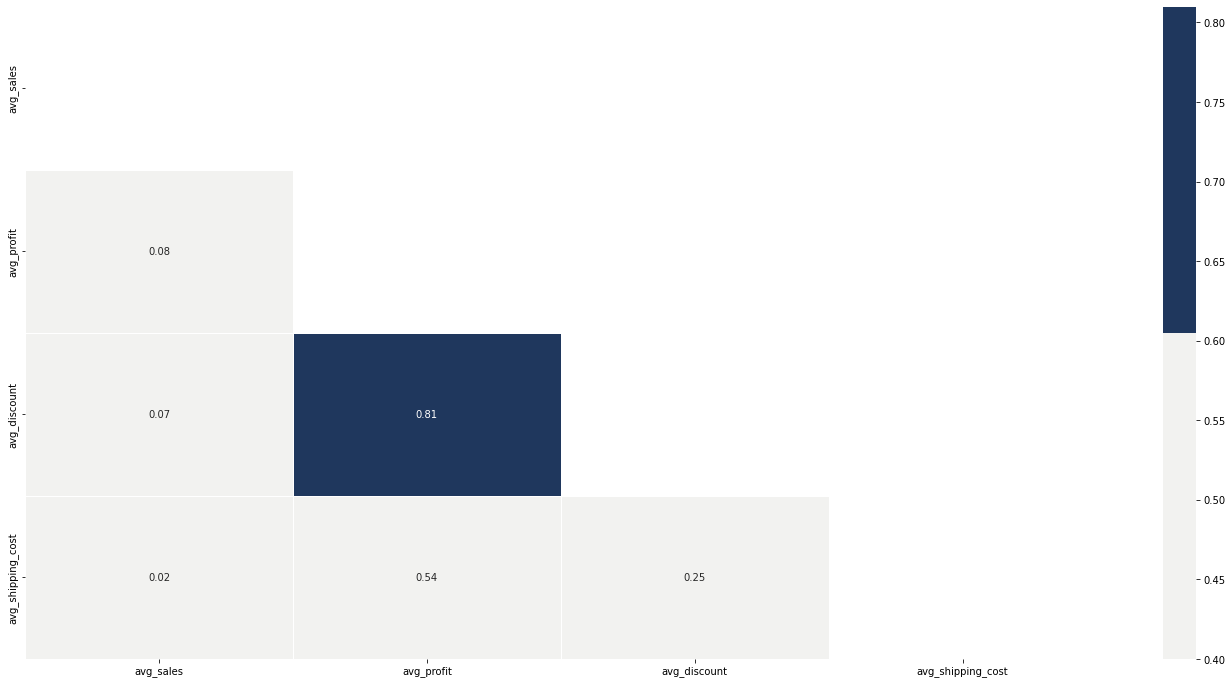

In [467]:
plt.figure(figsize=(24, 12))
correlations = df_train[features].corr().abs().round(2)
mask = np.triu(np.ones_like(correlations, dtype=bool))
sns.heatmap(correlations, mask=mask, linewidths=1, annot=True, cmap=['#F2F2F0','#1F375D'], vmin=0.40) #vmax=-0.40
plt.show()

## Preprocessing

In [468]:
min_max_scaler = MinMaxScaler()
df_train = min_max_scaler.fit_transform(df_train)

In [469]:
df_train = pd.DataFrame(min_max_scaler.fit_transform(df_train),
                        columns=features)

## Clustering

Let's take a look at our most important variables 

    Sales, Profit and a third one will "discover" right now, probably avg_discount
    as We just saw the correlation in the heatmap

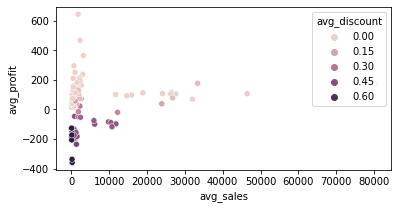

In [470]:
fig(6, 3)
sns.scatterplot(data=df_geolocation_abt, x='avg_sales', y='avg_profit', hue='avg_discount');

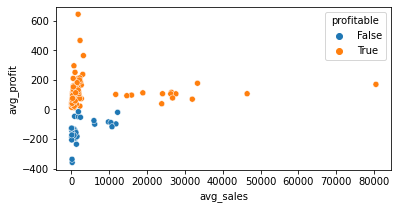

In [471]:
fig(6, 3)
sns.scatterplot(data=df_geolocation_abt, x='avg_sales', y='avg_profit', hue='profitable');

### K-Means


- **Advantages**

    Easy to interpret.
    
    It's fast (scales to large data sets)
<br>

- **Disadvantages**

    Sensitive to scale. Since k-means clustering works by calculating the distance between your data points and the size of centers of your clusters, it can be thrown off by situations where your variables have different scales. If one of your variables is on a much larger scale than the others, for example, that variable will have an outsized effect on the distance calculated. This means that you generally need to re-scale your data before using k-means clustering.
    
    Sensitive to Outliers (because it uses the "mean" to readjust clusters, 
    centroids can be dragged by outliers, or outliers might get their own cluster)
    
    Assumes spherical density. It is not suitable to identify clusters with irregular/ non-convex shapes.
       
    It requires to specify the number of clusters (k) in advance. 
    
    Sensitive to choice of seed. K-means clustering is relatively sensitive to the starting conditions that are used to initialize the algorithm
        
    Lacks consistency: K-means clustering gives varying results on different runs of an algorithm.
    
    
<br>

- **Statistical Assumptions**
   
    
    All variables have the same variance and is independent of the other.
    
    Variance of the distribution of each attribute (features) is spherical.

    The prior probability for all k clusters are the same, i.e. each cluster has roughly equal number of observations.
    
    
https://crunchingthedata.com/when-to-use-k-means-clustering/
    

### Inertia Vs. Distortion 

Model Selection, choosing K number of clusters

Sometimes you want to split your data into a predetermined number of groups or segments. Often, the number of clusters (K) is unclear, and you need an approach to select it.

A common metric is Inertia, defined as the sum of squares distance from each point to its cluster centroid.

Smaller values of Inertia correspond to tighter clusters, this means that we are penalizing spread out clusters and rewarding clusters that are tighter to their centroids.

The drawback of this metric is that its value sensitive to number of points in clusters. The more points you add, the more you will continue penalizing the inertia of a cluster, even if those points are relatively closer to the centroids than the existing points. 

Another metric is Distortion defined as the average of squared distance from each point to its cluster.

Smaller values of distortion corresponds to tighter clusters.

An advantage of distortion is that it doesn’t generally increase as more points are added (relative to inertia). This means that It doesn’t increase distortion, as closer points will actualy decrease the average distance to the cluster centroid.

Inertia Vs. Distortion 

Both Inertia and Distortion are measures of entropy per cluster.

Inertia will always increase as more members are added to each cluster, while this will not be the case with distortion. 

When the similarity of the points in the cluster are very relevant, you should use distortion and if you are more concerned that clusters should have a similar number of points, then you should use inertia.



### manhattan distance vs euclidean distance

manhattan (for high dimensionality, as high dimensionality often leads to difficulty in distinguishing distances between one point and the other, and the manhattan distance does better than the  euclidean distance in distinguishing these different distances once we move up the higher dimensional space)

**Finding K**

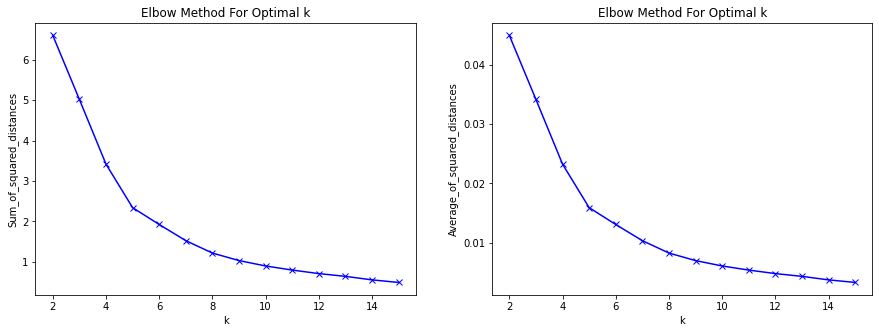

Wall time: 1.53 s


In [496]:
%%time
sum_of_squared_distances = []
average_of_squared_distances = []

K = range(2,16)
for k in K:
    km = KMeans(n_clusters=k, max_iter=500, random_state=42)
    km = km.fit(df_train[features])
    sum_of_squared_distances.append(km.inertia_) 
    
    distortion = ((df_train[features] - km.cluster_centers_[km.predict(df_train[features])])**2.0).sum(axis=1).mean()
    average_of_squared_distances.append(distortion)
     
plt.figure(figsize=(15, 5))
plt.subplot( 1, 2, 1 )
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.subplot( 1, 2, 2 )
plt.plot(K, average_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Average_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

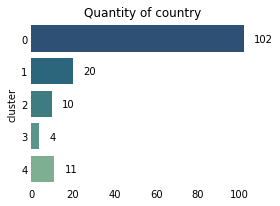

In [497]:
kmeans = KMeans(n_clusters=5, max_iter=500, random_state=42,)
labels = kmeans.fit_predict(df_train[features])
df_geolocation_abt['cluster'] = labels

fig(4,3)
count_plot(df_geolocation_abt, cluster_col="cluster", palette='crest_r', title=f'Quantity of {geolocation_group}');

### DBSCAN

https://machinelearningmastery.com/clustering-algorithms-with-python/

https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/#:~:text=DBSCAN%20is%20a%20density%2Dbased,points%20into%20a%20single%20cluster

https://ml-explained.com/blog/dbscan-explained

https://crunchingthedata.com/when-to-use-dbscan/



Useful when you expect all of your clusters to have a similar density.

- **Advantages**

    No need to specify the number of clusters as DBSCAN will automatically determine the clusters, dependent on how close points are from one another. 

    Robust to outliers. It allows for noise and will not automatically determine the outliers are part of a particular cluster. 

    Handles irregularly shaped and sized clusters. It'll also do a strong job of handling arbitrary shapes as it's going to be searching out points that are within epsilon distance of one another, and will stop whenever a gap occurs no matter what that boundary shape between the clusters are.

    Less sensitive to initialization conditions.

    Relatively fast.
    
<br>

- **Disadvantages**

    It's going to require two parameters, which means we need to search over more possible values to find that optimal solution. Also those hyper parameters can be very difficult to fine tune in higher dimensional space.

    Struggles with clusters of varying density. It will not do well with clusters of different density. So even if we have two clear groups, if for one group the points are about five units away from one another, and the other is one unit away depending on our distance metric. Depending on that distance between our two clusters that are, on average five units away or one unit away, it may be difficult to determine the differentiation between those two clusters.
    
    Struggles with high dimensional data. Like many clustering algorithms, the performance of DBSCAN tends to degrade in situations where there are many features.
    
<br>

- **Statistical Assumptions**

    Densities across all the clusters are the same.

    Cluster sizes or standard deviations are the same.
    
<br>

- **When to use**

    You suspect there may be irregularly shaped clusters.
    
    Data has outliers. DBSCAN is also a great option for cases where there are many outliers in your dataset. DBSCAN is able to detect outlying data point that do not belong to any clusters and exclude those data points from the the clusters.
    
    Anomaly detection. Since DBSCAN automatically detects outliers and excludes them from all clusters, DBSCAN is also a good option in cases where you want to be able to detect outliers in your dataset.

https://crunchingthedata.com/when-to-use-dbscan/


Text(0, 0.5, 'Distance')

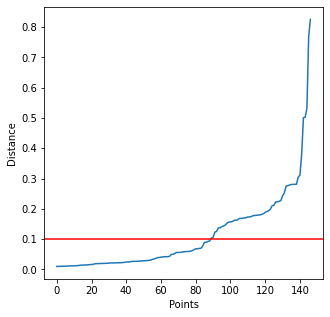

In [532]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=50)
neighbors = nearest_neighbors.fit(df_train[features])
distances, indices = neighbors.kneighbors(df_train[features])
distances = np.sort(distances[:,10], axis=0)

fig(5, 5)
plt.plot(distances)
plt.axhline(0.1, c='r')
plt.xlabel("Points")
plt.ylabel("Distance")

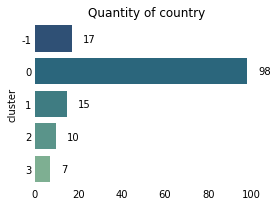

In [534]:
dbscan = DBSCAN(eps=.10, min_samples=int(len(df_train.columns)+1), ).fit(df_train[features]) # eps=.5, min_samples=15
df_geolocation_abt['cluster'] = dbscan.labels_

fig(4,3)
count_plot(df_geolocation_abt, cluster_col="cluster", palette='crest_r', title=f'Quantity of {geolocation_group}');

### Agglomerative Clustering

- **Advantages**

    Not so sensitive to initialization conditions
    
    Less sensitive to outliers. Outliers generally do not get added to a cluster until the end of the process when all of the other observations have already been handled.
    
    Less stringent assumptions about cluster shape. Hierarchical clustering algorithms do not make as stringent assumptions about the shape of your clusters. Depending on the distance metric you use, some cluster shapes may be detected more easily than others, but there is more flexibility.
    
    It can produce an ordering of objects, which may be informative for the display.
    
    We don’t have to pre-specify any particular number of clusters. We can obtain any desired number of clusters by cutting the Dendrogram at the proper level.
    
    Easy to decide the number of clusters by merely looking at the Dendrogram.

    Clusters may correspond to meaningful classification.

    Smaller clusters will be created, which may discover similarities in data.
    
<br>

- **Disadvantages**

    Relatively slow. One disadvantage of hierarchical clustering is that it is relatively slow. Hierarchical clustering generally requires you to compute the pairwise distance between all of the observations in your dataset, so the number of computations required grows rapidly as the size of your dataset increases.

    The algorithm can never undo what was done previously, which means if the objects may have been incorrectly grouped at an earlier stage, and the same result should be close to ensure it.
    
    The usage of various distance metrics for measuring distances between the clusters may produce different results. So performing multiple experiments and then comparing the result is recommended to help the actual results’ veracity.
    
    Different measures have problems with one or more of the following: Sensitivity to noise and outliers; Faces Difficulty when handling different sized clusters and convex shapes; It is breaking large clusters;  
    
    Sensitive to scale. Like many other clustering algorithms, many implementations of hierarchical clustering are very sensitive to the scale. This means that you may need to rescale your data before running your clustering. The exact level of sensitivity will vary depending on what distance metric you are using to calculate the distance between points.
    
    
<br>

- **Statistical Assumptions**
   
    
    It is very useful when the number of clusters are unknown.
    
    Need to identify most similar observations to a given data point. If you are operating in a scenario where you need to be able to identify the observations that are most similar to a given observation, hierarchical clustering is a great option. The dendrogram that is created for hierarchical clustering can identify exactly which observations are most similar to one another.
    
    Scaling of variables is an important issue as differences in scaling may affect your cluster solutions.
    
    

### Linkage
        Single Linkage (Minimum)
        
            Advantages 
                It can handle non-elliptical shapes.
                It's better for capturing clusters of different sizes.

            Disadvantages
                Simple Linkage methods are sensitive to noise and outliers.
                That means Simple Linkage methods can not group clusters 
                properly if there is any noise between the clusters.
                
        Complete Linkage (Maximum)
            
            Advantages
                Complete Linkage algorithms are less susceptible to noise and outliers.
                That means the Complete Linkage method also does well in separating
                clusters if there is any noise between the clusters.
                
            Disadvantages
                omplete linkage methods tend to break large clusters.
                Complete Linkage is biased towards globular clusters.


        Average Linkage
        
            Advantages
                The Average Linkage method also does well in separating clusters
                if there is any noise between the clusters.

            Disadvantages
                The average Linkage method is biased towards globular clusters.
                
_ps: BIRCH is an extension of hierarchical clustering that runs faster on large datasets. It also has lower memory requirements than standard hierarchical clustering._

In [535]:
# agglomerative_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(df_train[features])
# df_geolocation_abt['cluster'] = agglomerative_clustering.labels_

# fig(4,3)
# count_plot(df_geolocation_abt, cluster_col="cluster", palette='crest_r', title=f'Quantity of {geolocation_group}');

## Feature Importances

In [536]:
y = df_geolocation_abt['cluster']
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.3, random_state=0)

random_forest_model = RandomForestClassifier(n_estimators=500, min_samples_leaf=5, random_state=0)
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

          -1       1.00      0.14      0.25         7
           0       0.88      1.00      0.94        30
           1       1.00      1.00      1.00         6
           2       0.67      1.00      0.80         2
           3       0.00      1.00      0.00         0

    accuracy                           0.87        45
   macro avg       0.71      0.83      0.60        45
weighted avg       0.91      0.87      0.83        45



**I'll analyse all features, but We ideally We would analyse the variable of interest or the most importante features (variables)**

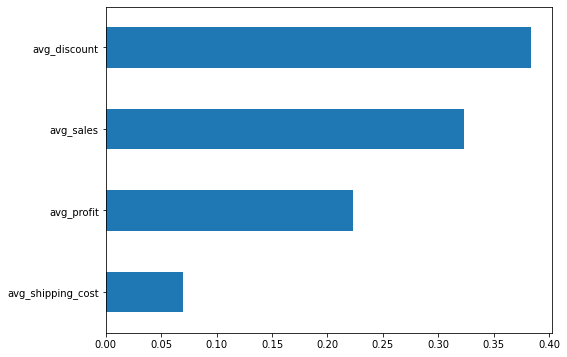

In [537]:
feature_importances = pd.Series(random_forest_model.feature_importances_, index=df_train.columns).sort_values(ascending=True)
feature_importances.plot.barh(figsize=(8, 6))
plt.show()

In [538]:
feature_importances.tail(14).index

Index(['avg_shipping_cost', 'avg_profit', 'avg_sales', 'avg_discount'], dtype='object')

## Analysis

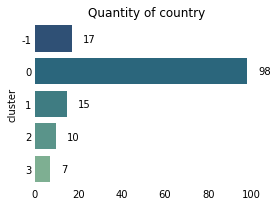

In [539]:
fig(4,3)
count_plot(df_geolocation_abt, cluster_col="cluster", palette='crest_r', title=f'Quantity of {geolocation_group}');

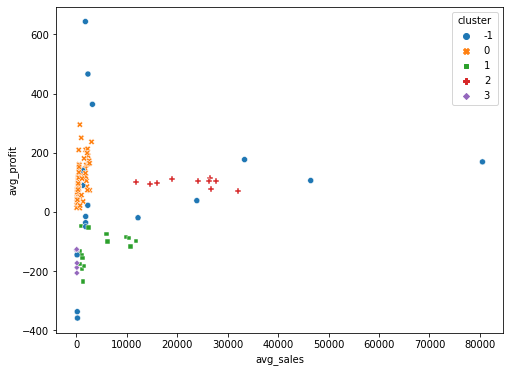

In [540]:
fig(8, 6)
sns.scatterplot(data=df_geolocation_abt, x='avg_sales', y='avg_profit', hue='cluster', style='cluster', palette='tab10');


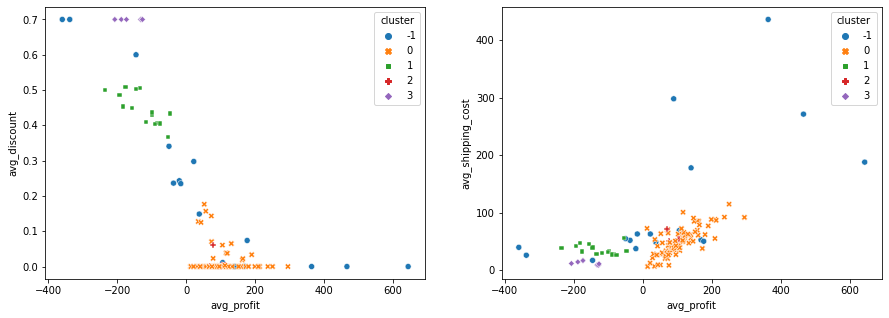

In [541]:
fig()
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_geolocation_abt, x='avg_profit', y='avg_discount', hue='cluster', style='cluster', palette='tab10');
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_geolocation_abt, x='avg_profit', y='avg_shipping_cost', hue='cluster', style='cluster', palette='tab10');

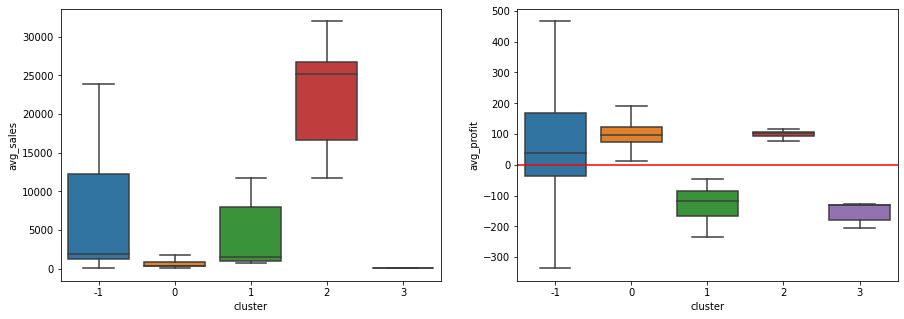

In [542]:
cluster_boxplot(cluster='cluster', y=['avg_sales', 'avg_profit'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

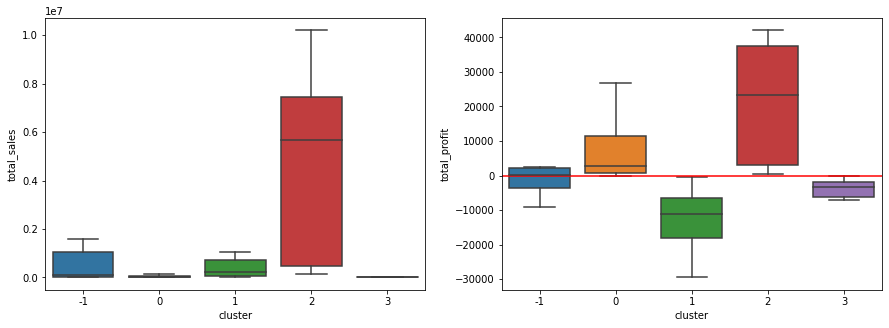

In [543]:
cluster_boxplot(cluster='cluster', y=['total_sales', 'total_profit'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

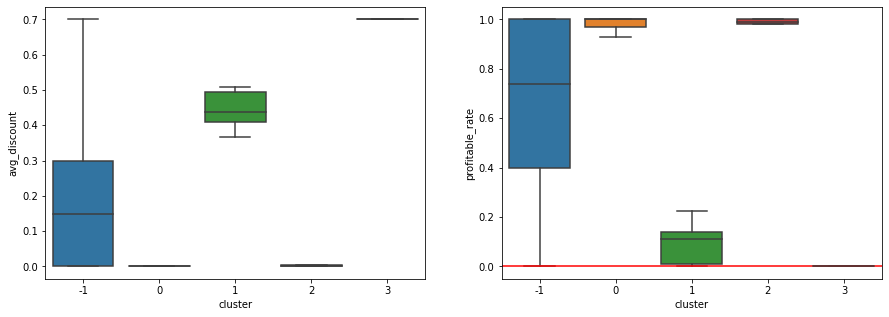

In [544]:
cluster_boxplot(cluster='cluster', y=['avg_discount', 'profitable_rate'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

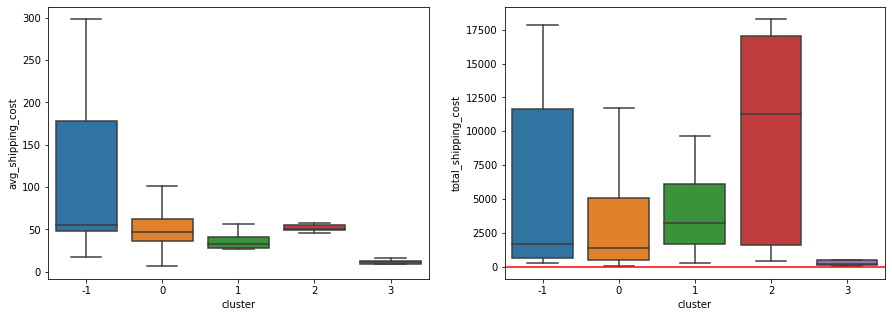

In [545]:
cluster_boxplot(cluster='cluster', y=['avg_shipping_cost', 'total_shipping_cost'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

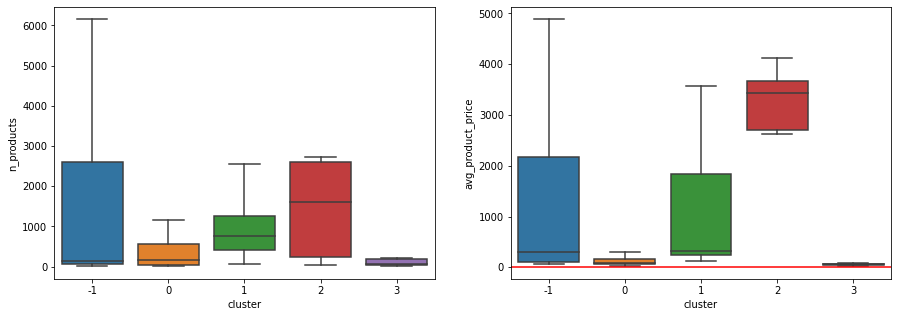

In [546]:
cluster_boxplot(cluster='cluster', y=['n_products', 'avg_product_price'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

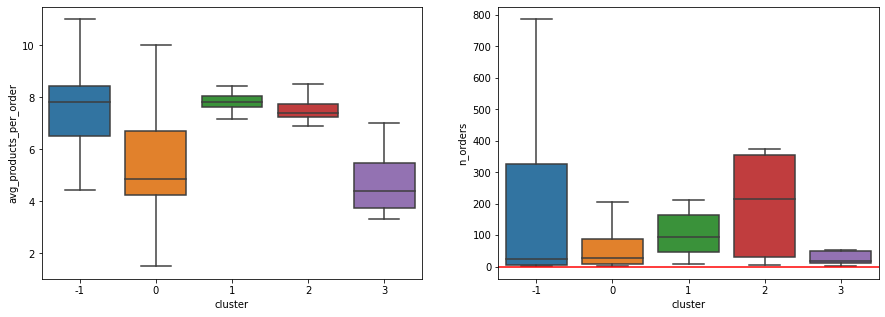

In [547]:
cluster_boxplot(cluster='cluster', y=['avg_products_per_order', 'n_orders'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

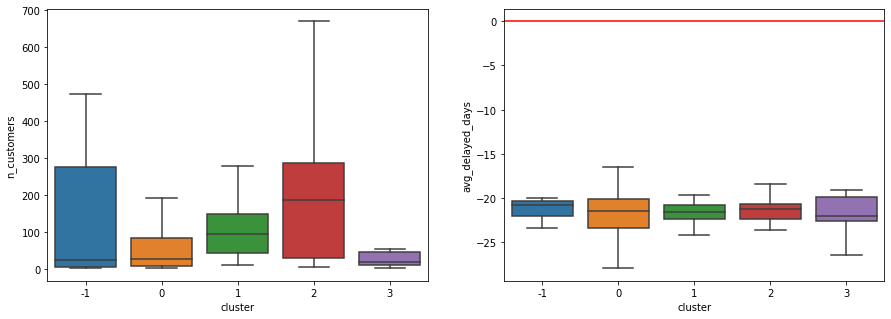

In [548]:
cluster_boxplot(cluster='cluster', y=['n_customers', 'avg_delayed_days'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

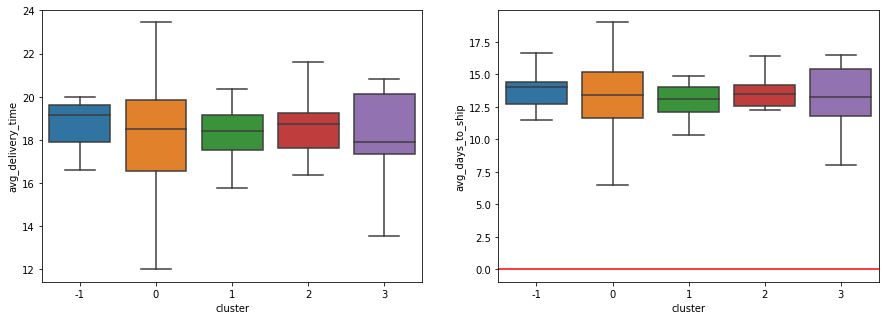

In [549]:
cluster_boxplot(cluster='cluster', y=['avg_delivery_time', 'avg_days_to_ship'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

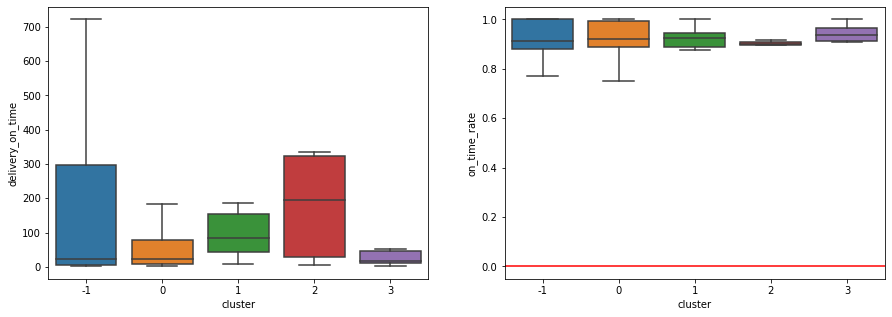

In [550]:
cluster_boxplot(cluster='cluster', y=['delivery_on_time', 'on_time_rate'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

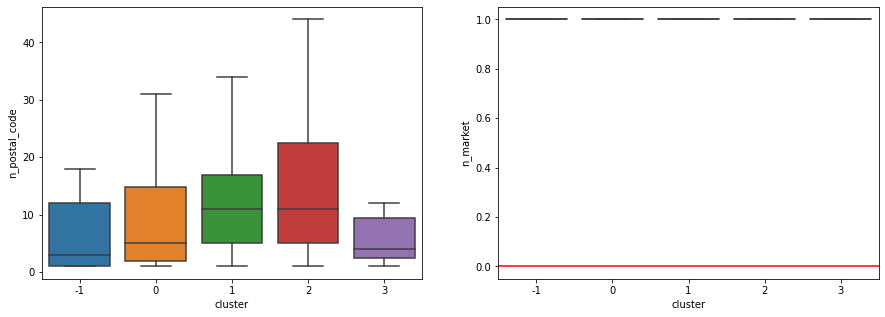

In [551]:
cluster_boxplot(cluster='cluster', y=['n_postal_code', 'n_market'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

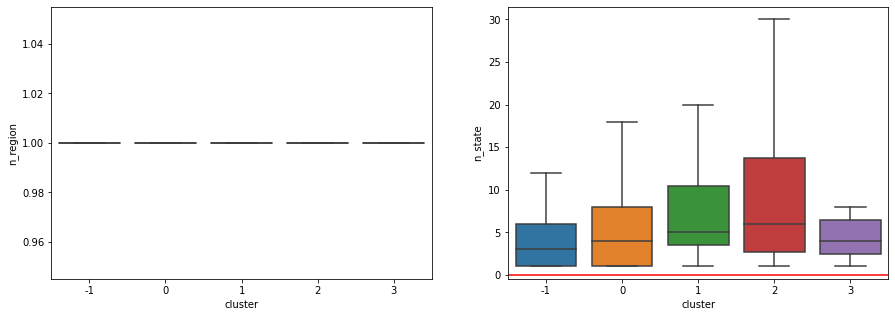

In [552]:
cluster_boxplot(cluster='cluster', y=['n_region', 'n_state'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

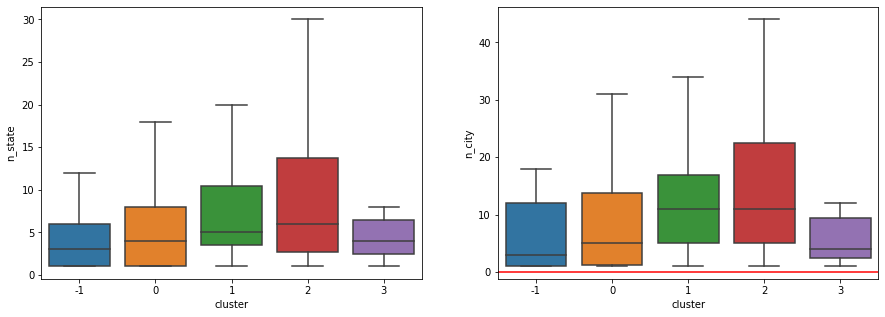

In [553]:
cluster_boxplot(cluster='cluster', y=['n_state', 'n_city'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

In [554]:
df_geolocation_abt.columns

Index(['country', 'n_orders', 'n_customers', 'n_postal_code', 'n_market',
       'n_region', 'n_state', 'n_city', 'total_sales', 'avg_sales',
       'total_profit', 'avg_profit', 'avg_delivery_time', 'avg_days_to_ship',
       'avg_delayed_days', 'delivery_on_time', 'on_time_rate', 'n_products',
       'avg_products_per_order', 'avg_discount', 'avg_product_price',
       'total_shipping_cost', 'avg_shipping_cost', 'profitable_rate',
       'profitable', 'cluster'],
      dtype='object')